# Deep Learning in 3D Vision

*Notebook created by [Albert Mosella-Montoro](https://www.linkedin.com/in/albertmosellamontoro) for the [UPC School](https://www.talent.upc.edu/ing/) (2025)*

**Duration:** 1 hour and 30 min

This notebook provides a hands-on exploration of 3D data processing and neural network implementation using Python. In this notebook, you'll build and experiment with two models— PointNet and a Graph Neural Network—to analyze and classify a dataset of 40 distinct geometric shapes.

**Note:** This notebook assumes prior knowledge of PyTorch Geometric's data structures. If you are not familiar with them, please carefully review this [webpage](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html), especially the sections on **Data Handling Graphs** and **Mini-Batches**.

# Lab Tasks

## Core Tasks

### 1. 3D Data Manipulation
- Explore the Geometric Shapes dataset and learn how to create a point cloud from a 3D shape.

- Explore different techniques to create a graph from a point cloud.

- Create a PyTorch Geometric Dataset that uses the Geometric Shapes dataset.

### 2. PointNet
- Implement the different modules of PointNet.

- Train the PointNet network using the previously generated dataset.

### 3. Graph Based Network
- Implement a voxel pooling layer.

- Implement a Graph Neural Network architecture.

- Train the GNN network using the previously generated dataset.


***This notebook can be run on either a GPU or CPU. If you encounter problems with the Colab GPU, you can complete the lab using Colab CPU.***

# Dependencies and helper viewer functions

## Dependencies

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torchmetrics

## Helper viewer functions

`plot_3d_mesh` function

This function visualizes a 3D mesh given its vertices and faces.

- **`vertices`**: A tensor of shape `(num_vertices, 3)` representing the coordinates of each vertex in 3D space.
- **`faces`**: A tensor of shape `(3, num_faces)` representing the indices of the vertices that form each triangular face of the mesh.

`plot_2d_points` function

This function visualizes a set of 2D points and optionally the edges connecting them.

- **`points`**: A tensor of shape `(num_points, 2)` representing the coordinates of each point in 2D space.
- **`edges`** (optional): A tensor of shape `(2, num_edges)` representing the indices of the points that form each edge. If provided, lines are drawn between connected points.
- **`highlight_indices`** (optional): A list or tensor of indices of points to be highlighted in the plot. Non-highlighted points are shown in light gray.

`visualize_batch_graphs` function

This function visualizes individual graphs within a PyTorch Geometric `Batch` object.

- **`batch`**: A `torch_geometric.data.Batch` object containing multiple graphs.

The function iterates through the unique graph indices in the batch, extracts the nodes, positions, and edges for each individual graph, and then uses the `plot_2d_points` function to visualize each graph separately. It also prints information about the number of samples in the batch and the current sample being visualized.

In [ ]:
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_mesh(vertices, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.plot_trisurf(
        vertices[:, 0], vertices[:, 1], vertices[:, 2],
        triangles=faces.t(), antialiased=False
    )
    plt.show()

def plot_2d_points(points, edges=None, highlight_indices=None):
    fig, ax = plt.subplots(figsize=(4, 4))

    if edges is not None:
        for src, dst in edges.t().tolist():
            src_pt, dst_pt = points[src].tolist(), points[dst].tolist()
            ax.plot([src_pt[0], dst_pt[0]], [src_pt[1], dst_pt[1]], linewidth=1, color='black')

    if highlight_indices is None:
        ax.scatter(points[:, 0], points[:, 1], s=50, zorder=1000)
    else:
        mask = torch.zeros(points.size(0), dtype=torch.bool)
        mask[highlight_indices] = True
        ax.scatter(points[~mask, 0], points[~mask, 1], s=50, color='lightgray', zorder=1000)
        ax.scatter(points[mask, 0], points[mask, 1], s=50, zorder=1000)

    ax.axis('off')
    plt.show()


def visualize_batch_graphs(batch):
    unique_batches = torch.unique(data_sample.batch)
    print(f"Batch contains {len(unique_batches)} samples.")

    for batch_idx in unique_batches:
        print(f"\nVisualizing sample {batch_idx.item()} from the batch:")

        # Mask for nodes belonging to the current batch graph
        node_mask = (data_sample.batch == batch_idx)
        node_indices = torch.where(node_mask)[0]
        pos = data_sample.pos[node_mask]

        # Mask for edges where both nodes belong to the current batch graph
        edge_mask = node_mask[data_sample.edge_index[0]] & node_mask[data_sample.edge_index[1]]
        edge_index = data_sample.edge_index[:, edge_mask]

        # Map global node indices to local indices for the current graph
        global_to_local = torch.full((data_sample.num_nodes,), -1, dtype=torch.long, device=pos.device)
        global_to_local[node_indices] = torch.arange(pos.size(0), device=pos.device)
        local_edge_index = global_to_local[edge_index]

        # Plot the current graph
        plot_2d_points(pos, local_edge_index)

# 3D Data Manipulation



In this section you will learn how to manipulate 3D data using[ Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/#). You'll work with the Geometric Shapes dataset, discover how to sample point clouds from the surfaces of 3D objects, and transform these point clouds into graph representations for further analysis.

## Geometric Shapes dataset

First, let's explore the [Geometric Shapes dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.GeometricShapes.html).

Your tasks in this section are:

- **Determine the following for the training split:**
  - The number of samples
  - The number of features
  - The number of classes

- **For three selected samples from the dataset, retrieve:**
  - The number of vertices (nodes)
  - The number of faces
  - The dimensionality of the 3D coordinates
  - The label of each sample

Keep in mind that the Geometric Shapes dataset is built upon PyTorch Geometric’s [InMemoryDataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.InMemoryDataset.html), and each sample is represented using the [Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html) structure. This setup allows for efficient access and manipulation of geometric data throughout your experiments.

In [ ]:
from torch_geometric.datasets import GeometricShapes

path_to_geometric_shapes = 'data/GeometricShapes'
dataset = GeometricShapes(root=path_to_geometric_shapes, train=True)

# Load and visualize the first few examples
# TODO: print the len of the dataset.
print(f'Dataset size: {...}')

# TODO: print the len of the dataset.
print(f'Number of features: {...}')

# TODO: get the number of classes of the dataset
print(f'Number of classes: {...}')

for i in range(1,4):
    data = dataset[i]
    print(f'\nExample {i}:')
    # TODO: get the number of vertices (nodes) for the i sample
    print(f'  Number of nodes: {...}')

    # TODO: get faces for the i sample
    print(f'  Mesh faces shape: {...}')

    # TODO: get position of the nodes for the i sample
    print(f'  Position shape: {...}')

    #TODO: get the label for the i sample
    print(f'  Label: {...}')


    plot_3d_mesh(data.pos, data.face)

## Surface Mesh Sampling




To convert a 3D mesh into a point cloud, we could use the mesh’s vertices directly; however, this approach does not let us control the number of points and does not ensure that all samples have the same point count. Alternatively, we can uniformly sample points across the mesh surface. PyTorch Geometric offers the [SamplePoints](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.SamplePoints.html?highlight=samplepoints) method for this purpose.

In [ ]:
from torch_geometric.transforms import SamplePoints

# Define the number of points to sample
num_points = 256

# Create a SamplePoints transform
sample_transform = SamplePoints(num_points)

# Generate point clouds from the dataset by applying the transform
point_clouds = [sample_transform(data).pos for data in dataset]

# Print the shape of the first few point clouds to confirm the conversion
print("Shape of the first few point clouds:")
for i in range(min(3, len(point_clouds))):
    print(f"Point cloud {i} shape: {point_clouds[i].shape}")

In [ ]:
# Visualize the original mesh and the sampled point cloud for comparison
print("Visualizing the original mesh (Example 0):")
# TODO: Plot the original mesh using the provided viewer function.
plot_3d_mesh(...)

print("Visualizing the sampled point cloud (Example 0):")
# TODO: Plot the point cloud in 2D using the provided viewer function.
plot_2d_points(...)

## Generate graphs from Point Clouds

To convert a point cloud into a graph, we have two main approaches: kNN and the radius proximity policies. Your task is to convert the previous point clouds into graphs using both methods. The resulting graphs should include self-loops. PyTorch Geometric provides two methods to implement these policies: [kNN](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.knn_graph.html#torch_geometric.nn.pool.knn_graph) and [radius](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.radius_graph.html?highlight=radius_graph).



### kNN Proximity Policy

In [ ]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data

graph_data_list_knn = []
for pos in point_clouds:
    data = Data(pos=pos)
    # TODO: Generate KNN graph with k=6 with self-loops
    data.edge_index = knn_graph(...)

    graph_data_list_knn.append(data)

# Print information about the first few graphs
print("Information about the first few KNN graphs:")
for i in range(3):
    data = graph_data_list_knn[i]
    print(f"\nKNN Graph {i}:")
    print(f"  Number of nodes: {data.num_nodes}")
    print(f"  Number of edges: {data.num_edges}")
    print(f"  Edge index shape: {data.edge_index.shape}")

# Visualize the first KNN graph
print("\nVisualizing the first KNN graph:")
# TODO: visualize the graph using the provided helper viewer function
plot_2d_points(...)

### Radius Proximity Policy


In [ ]:
from torch_geometric.nn import radius_graph

# We need to choose an appropriate radius. A small radius will result in sparse graphs,
# while a large radius will result in dense graphs. Let's try a radius of 0.1 as a starting point.
radius = 0.1

graph_data_list_radius = []
for pos in point_clouds:
    data = Data(pos=pos)

    # TODO: Generate Radius graph with self-loops
    data.edge_index = radius_graph(...)

    graph_data_list_radius.append(data)

# Print information about the first few graphs
print("Information about the first few Radius graphs:")
for i in range(min(3, len(graph_data_list_radius))):
    data = graph_data_list_radius[i]
    print(f"\nRadius Graph {i}:")
    print(f"  Number of nodes: {data.num_nodes}")
    print(f"  Number of edges: {data.num_edges}")
    print(f"  Edge index shape: {data.edge_index.shape}")

# Visualize the first Radius graph
print("\nVisualizing the first Radius graph:")
# TODO: visualize the graph using the provided helper viewer function
plot_2d_points(...)

**Question:** Which pros and cons do you think those methods have?

## Create a PyTorch Geometric Dataset


Next, we'll combine everything we've learned to build a [Dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Dataset.html#torch_geometric.data.Dataset) class that loads data from the `GeometricShapesDataset`. This dataset will handle mesh-to-point-cloud conversions and graph constructions depending on user configuration, though **note that the only supported graph construction policy is kNN**. Complete the missing components in the provided class template to implement this functionality.

**Note:** The position of the points will be centered and normalzied to the interval (-1, 1), you can use the [NormalizeScale](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.NormalizeScale.html?highlight=normalizescale) transformation.

In [ ]:
from torch_geometric.data import Dataset, Data
from torch_geometric.transforms import NormalizeScale
import os

class GeometricShapesDataset(Dataset):
    def __init__(self, root, train=True, num_points=1000, k=6, return_type='point_cloud', transform=None, pre_transform=None):
        self.num_points = num_points
        self.k = k
        self.train = train
        self.return_type = return_type
        self.point_clouds = []
        self.knn_graphs = []
        # TODO: Initialize the Geometric Shapes dataset
        self.data = ...

        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.data.raw_file_names

    @property
    def processed_file_names(self):
        split_prefix = 'train_' if self.train else 'val_'
        return [f'{split_prefix}point_cloud_{i}.pt' for i in range(len(self.data))] + \
               [f'{split_prefix}knn_graph_{i}.pt' for i in range(len(self.data))]

    def download(self):
        pass

    def process(self):
        # TODO: Define the Sample Points transform
        sample_transform = ...

        # TODO: Define a transformation that centers and normalizes the point cloud to the interval (-1, 1)
        normalize_transform = ...

        split_prefix = 'train_' if self.train else 'val_'

        for i, data in enumerate(self.data):
            point_cloud_data = sample_transform(data)
            # TODO: Apply the normalize transform
            point_cloud_data = ...

            torch.save(point_cloud_data, os.path.join(self.processed_dir, f'{split_prefix}point_cloud_{i}.pt'))

            # Process KNN graphs
            data_pos = Data(pos=point_cloud_data.pos)
            #TODO: Create the knn graph that uses the defined K and self-loops
            edge_index = ...

            knn_graph_data = Data(x=point_cloud_data.pos, pos=point_cloud_data.pos, edge_index=edge_index, y=data.y)

            torch.save(knn_graph_data, os.path.join(self.processed_dir, f'{split_prefix}knn_graph_{i}.pt'))


    def len(self):
        return len(self.data)

    def get(self, idx):
        split_prefix = 'train_' if self.train else 'val_'
        if self.return_type == 'point_cloud':
            return torch.load(os.path.join(self.processed_dir, f'{split_prefix}point_cloud_{idx}.pt'), weights_only=False)
        elif self.return_type == 'knn_graph':
            return torch.load(os.path.join(self.processed_dir, f'{split_prefix}knn_graph_{idx}.pt'), weights_only=False)
        else:
            raise ValueError("return_type must be 'point_cloud' or 'knn_graph'")

# Example usage:
# Point Clouds
train_point_cloud_dataset = GeometricShapesDataset(root=path_to_geometric_shapes, train=True, return_type='point_cloud')
print(f"\nCustom Training Dataset size (Point Clouds): {len(train_point_cloud_dataset)}")
print(f"Example 0 (Train Point Cloud):\n{train_point_cloud_dataset.get(0)}")
val_point_cloud_dataset = GeometricShapesDataset(root=path_to_geometric_shapes, train=False, return_type='point_cloud')
print(f"\nCustom Validation Dataset size (Point Clouds): {len(val_point_cloud_dataset)}")
print(f"Example 0 (Val Point Cloud):\n{val_point_cloud_dataset.get(0)}")

# knn
train_knn_graph_dataset = GeometricShapesDataset(root=path_to_geometric_shapes, train=True, return_type='knn_graph')
print(f"\nCustom Training Dataset size (KNN Graphs): {len(train_knn_graph_dataset)}")
print(f"Example 0 (Train KNN Graph):\n{train_knn_graph_dataset.get(0)}")
val_knn_graph_dataset = GeometricShapesDataset(root=path_to_geometric_shapes, train=False, return_type='knn_graph')
print(f"\nCustom Validation Dataset size (KNN Graphs): {len(val_knn_graph_dataset)}")
print(f"Example 0 (Val KNN Graph):\n{val_knn_graph_dataset.get(0)}")

# PointNet

## Implement PointNet Architecture

In this section, we'll implement the PointNet architecture outlined in the image below to classify 3D shapes from our custom dataset.

**Note**: We've adjusted the original architecture; in each MLP, we specify the number of output channels for each hidden layer.

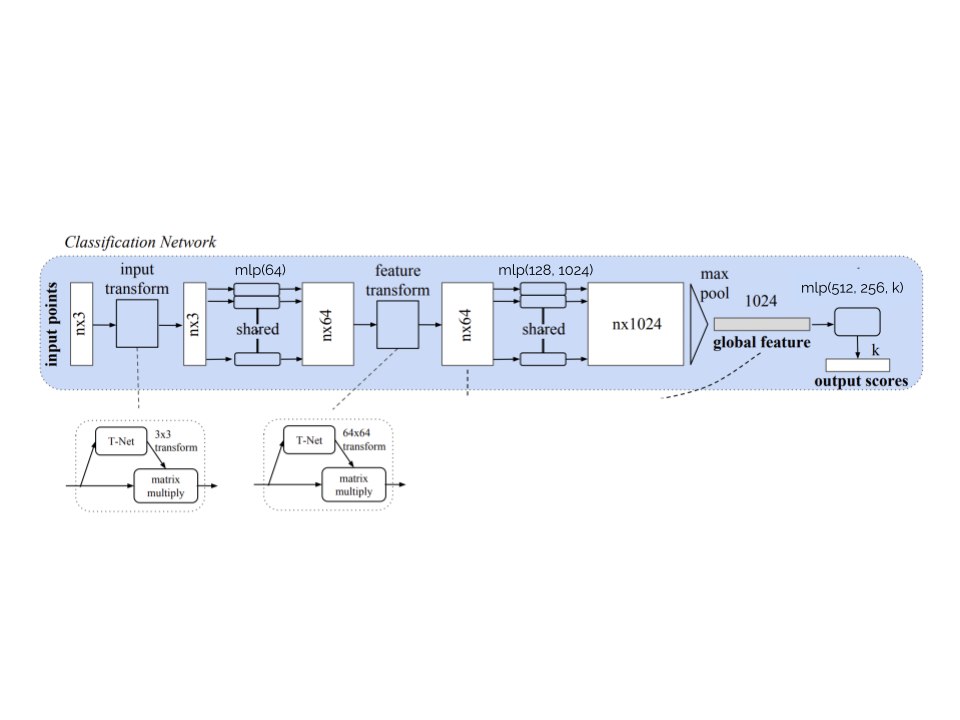

### T-Net Implementation


First, we'll implement the T-Net. This network learns affine transformations in both the input space and feature space. Below we've provided the implementation of T-Net.

In [ ]:
import torch.nn as nn

class TNet(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k

        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):

        input_dims = x.size(1)
        num_points = x.size(2)

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)

        # Max pooling over points
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) # (batch_size, 1024)

        x = F.relu(self.bn4(self.fc1(x)), inplace=True)
        x = F.relu(self.bn5(self.fc2(x)), inplace=True)
        x = self.fc3(x)

        # Reshape to (batch_size, k, k) and add identity matrix to ensure orthogonality
        iden = torch.eye(input_dims, requires_grad=True).repeat(x.size(0), 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, input_dims, input_dims) + iden

        return x

### Backbone implementation


With the T-Net implemented, we've assembled all components needed to construct the PointNet architecture. Like many classification networks, it consists of two stages: **feature extraction** (pre-max-pooling) and **classification** (post-max-pooling). For the feature extraction stage, implement the MLP layers using [Conv1d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) to process individual points efficiently. **Important**: Follow each Conv1d layer with [BatchNorm1d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d) and ReLU operations, ideally organized using PyTorch's [Sequential](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html#sequential) container for cleaner code structure. For the classification stage, we'll use Linear layers followed by BatchNorm1d and ReLU operations. **Important**: The final Linear layer will exclude both batch normalization and activation functions.

In [ ]:
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=40):
        super(PointNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # TODO: Define the input_transform T-Net
        self.input_transform = ...

        # TODO: Define the first set of conv1d
        self.conv1 = ...

        # TODO: Define the feature_transform T-Net
        self.feature_transform = ...

        # TODO: Define the second set of conv1d
        self.conv2 = ...

        # TODO: Define the classification stage
        self.classify = ...

    def forward(self, x):
        # TODO: Apply the input net
        trans = ...


        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)

        # TODO: Forward the first set of conv layers
        x = ...

        # TODO: Apply feature T-Net
        feature_matrix = ...

        # Multiply input the transformation matrix
        x = x.transpose(2, 1)
        x = torch.bmm(x, feature_matrix)
        x = x.transpose(2, 1)

        # TODO: Forward the second set of conv layers
        x = ...

        # Global max pooling across the points
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) # Reshape to (batch_size, 1024)

        # TODO: Forward the classification stage
        output = ...

        return output


Next, we'll analyze our model's complexity by counting its trainable parameters.

In [ ]:
def count_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_million = num_params / 1_000_000
    print(f"Number of trainable parameters: {num_params_million:.3f}M")

model = PointNet(in_channels=3, num_classes=40) #Init model

count_parameters(model)



## Training

Now, we will train PointNet using the GeometricShapes dataset.

### Accuracy Metric


To measure the effectiveness of our classification, we'll use the [Accuracy metric](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html). Rather than implementing this metric ourselves, we'll utilize the version provided by torchmetrics. Refer to the [documentation](https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html) for guidance on how to use it.



In [ ]:
import torchmetrics.classification

accuracy_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=dataset.num_classes)


### Training Loop


First, we will implement the training loop for a single epoch. Complete the provided function to enable network training.

In [ ]:
def train(model, train_loader, optimizer, criterion, accuracy_metric, device='cuda'):
    # TODO: Put model in training mode
    ...

    total_loss = 0
    accuracy_metric.reset()

    for data in train_loader:
        # TODO: move data to the proper device
        data = ...

        # TODO: Put to zero the gradients of the optimizer
        ...

        # Reshape the point cloud data to the dense PointNet input format (batch_size, num_points, num_channels)
        # data.pos shape from DataLoader is typically (total_num_points_in_batch, num_channels=3)
        # We need to reshape it to (batch_size, num_points, num_channels)
        batch_size = data.batch.max().item() + 1 if data.batch.numel() > 0 else 1 # Handle potential empty batch or batch size 1
        num_points = data.pos.size(0) // batch_size
        point_cloud_input = data.pos.view(batch_size, num_points, data.pos.size(1))
        point_cloud_input = point_cloud_input.permute(0, 2, 1)

        # TODO: Pass the input data through the model
        logits = ...

        # TODO: Compute the loss
        loss = ...

        # TODO: Compute gradients and update weights
        ...
        ...

        total_loss += loss.item()

        # Update accuracy metric
        preds = logits.argmax(dim=1)
        accuracy_metric.update(preds, data.y)

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_metric.compute().item()

    return avg_loss, accuracy

### Validation Loop

Now, we will implement the validation loop for a single epoch. Complete the provided function to enable network training.

In [ ]:
def validate(model, loader, criterion, accuracy_metric, device='cuda'):
    # TODO: Put model in eval mode
    ...

    total_loss = 0
    accuracy_metric.reset()


    with torch.no_grad():
        for data in loader:
            # TODO: move data to the proper device
            data = ...

            # Reshape the point cloud data to the dense PointNet input format (batch_size, num_points, num_channels)
            # data.pos shape from DataLoader is typically (total_num_points_in_batch, num_channels=3)
            # We need to reshape it to (batch_size, num_points, num_channels)
            batch_size = data.batch.max().item() + 1 if data.batch.numel() > 0 else 1
            num_points = data.pos.size(0) // batch_size
            point_cloud_input = data.pos.view(batch_size, num_points, data.pos.size(1))
            point_cloud_input = point_cloud_input.permute(0, 2, 1)

            # TODO: Pass the input data through the model
            logits = ...

            # TODO: Compute the loss
            loss = ...

            total_loss += loss.item()

            # Update accuracy metric
            preds = logits.argmax(dim=1)
            accuracy_metric.update(preds, data.y)

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_metric.compute().item()

    return avg_loss, accuracy

**Question:** Why is it necessary to reshape the input point cloud from our custom dataset before processing it in the model? Explain that with your own words.

### Train the network

Finally, we'll train our model using the `GeometricShapesDataset`, which provides point clouds sampled from the dataset's 3D objects (1000 points per sample). The training configuration includes:
- **50 epochs** with a **batch size of 32**
- **Adam optimizer** (learning rate=0.001)
- **CrossEntropyLoss** as the objective function
- **Use the [Dataloader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader) provided by Pytorch Geometric, which will create a [Batch](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Batch.html#torch_geometric.data.Batch) data structure**

Implement this setup to train the model

In [ ]:
import torch.optim as optim
from torch_geometric.loader import DataLoader

num_points = 1000
bs = 32
lr = 0.001
num_epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#TODO: Define the dataset for the training split
train_dataset = ...

#TODO: Define the dataset for the validation split
val_dataset = ...

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# TODO: Init the model
model = ...

# TODO: Move model to the proper device
model = ...

accuracy_metric.to(device)

# TODO: Define the loss
criterion = ...

# TODO: Define the optimizer
optimizer = ...


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("\nStarting training...")
for epoch in range(num_epochs):

    # TODO: Call the train method
    train_loss, train_acc = ...

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    # TODO: Call the validation method
    val_loss, val_acc = ...

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining finished.")

**Plot training curves**

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Question:** Did the results match your expectations? Considering the number of parameters in the model and the accuracy achieved, would you consider the model's performance acceptable? Please explain your reasoning.

# Graph based network with pooling layers


## Understanding voxel pooling

In this section, we'll explore the voxel pooling algorithm. In 2D networks,  pooling layersa are known to increase the receptive field, speed up computations, and often improve results. To start, we will select a sample from the dataset for our experiments.


In [ ]:
# get first sample of the dataset for our experiments
dataset_devel = GeometricShapesDataset(root=path_to_geometric_shapes, num_points=num_points, train=True, return_type='knn_graph')
loader = DataLoader(dataset_devel, batch_size=1, shuffle=False)
data_sample = next(iter(loader))
# visualize data
plot_2d_points(data_sample.pos, data_sample.edge_index)

Now, we will implement the `voxel_pooling` function to downsample the input data. This function will take a [`Batch`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Batch.html#torch_geometric.data.Batch) data structure and a specified `voxel_size`, returning the `new_positions` and the updated `new_batch` vector.

To implement this function, you will need to use:
- The [`voxel_grid`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.voxel_grid.html?highlight=voxel_grid#torch_geometric.nn.pool.voxel_grid) method from PyTorch Geometric to assign each point to a voxel cluster.
- The [`scatter`](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter) operation from torch_scatter to compute the average position of all nodes within each voxel.

**Note:** The `Batch` object includes a `batch` attribute, which is a vector indicating the batch assignment for each node in the graph.

In [ ]:
import torch_geometric.nn as nn_pyg
from torch_geometric.nn.pool import voxel_grid
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.data import Batch
from torch_scatter import scatter

def voxel_pooling(data, voxel_size):

    # TODO: Generate a voxel grid
    cluster = ...

    cluster, perm = consecutive_cluster(cluster) # returns the cluster with the voxel that contains a point and the mask to filter the batch vector.
    # TODO: Using the previously computed clusters, calculate the new positions with the scatter function.
    #       Each new position should be the average of all node positions within its corresponding voxel.
    new_pos = ...

    new_batch = data.batch[perm]


    return new_pos, new_batch


voxel_size = 0.1

pos_pooled, batch_pooled = voxel_pooling(data_sample, voxel_size=voxel_size)


print(f"Original number of points: {data_sample.num_nodes}")
print(f"Number of points after voxel pooling (average): {pos_pooled.size(0)}")

# Visualize before pooling
print("Original Point Cloud:")
plot_2d_points(data_sample.pos)

# Visualize after pooling (just the new point locations)
print("Point Cloud after Voxel Pooling (Average):")
plot_2d_points(pos_pooled)

After performing voxel pooling, we will reconstruct the graph using the **kNN policy** (k=6). Complete the missing parts.


In [ ]:
# Create a Data object for the pooled points
pooled_data = Data(pos=pos_pooled, batch=batch_pooled)

k_knn = 6
# TODO: Generate KNN graph on the pooled points
edge_index_pooled = ...

# Add the new edge index to the pooled data object
pooled_data.edge_index = edge_index_pooled

print(f"\nNumber of nodes in the pooled graph: {pooled_data.num_nodes}")
print(f"Number of edges in the pooled graph: {pooled_data.num_edges}")
print(f"Edge index shape of the pooled graph: {pooled_data.edge_index.shape}")

# Visualize the pooled graph
print("\nVisualizing the original KNN graph:")
plot_2d_points(data_sample.pos, data_sample.edge_index)

print("\nVisualizing the pooled KNN graph:")
plot_2d_points(pooled_data.pos, pooled_data.edge_index)

## Define Voxel Pooling Layer

Create a PyTorch layer that downsamples an input point cloud and reconstructs its graph structure. The layer will:  
1. Compute **new positions** as the average of all nodes within the same voxel.  
2. Calculate **new features** using either `max` or `average`, depending on user configuration.
3. Recompute the graph.

**Note:** To compute the pooled features, we need to extend the previous voxel_pooling function. We won't create a new function; instead, we'll apply the required logic within the forward method of our layer.

In [ ]:
class VoxelPoolingWithKNN(nn.Module):
    def __init__(self, voxel_size, k, pooling_type='avg'):
        super().__init__()

        self.voxel_size = voxel_size
        self.k = k

        if pooling_type == 'max':
            self.pooling_type = "max"
        elif pooling_type == 'avg':
           self.pooling_type = "mean"
        else:
            raise ValueError("pooling_type must be 'avg' or 'max'")



    def forward(self, data):

        # TODO: Downsample the point cloud
        ...
        ...
        ...
        ...
        ...

        data.x = new_x
        data.pos = new_pos
        data.batch = new_batch
        # TODO: Generate the graph
        data.edge_index = ...

        return data



dataset_devel = GeometricShapesDataset(root=path_to_geometric_shapes, num_points=num_points, train=True, return_type='knn_graph')
loader = DataLoader(dataset_devel, batch_size=2, shuffle=False)
data_sample = next(iter(loader))
print(data_sample)
# visualize original data:
print("\nOriginal batch visualization")
visualize_batch_graphs(data_sample)

voxel_size = 0.1
k_knn = 6
pooling_layer_avg = VoxelPoolingWithKNN(voxel_size=voxel_size, k=k_knn, pooling_type='avg')

pooled_data_avg = pooling_layer_avg(data_sample)


print("\nOriginal batch visualization")
visualize_batch_graphs(pooled_data_avg)

print("\nInformation about the pooled data:")
print(f"  Number of nodes: {pooled_data_avg.num_nodes}")
print(f"  Number of edges: {pooled_data_avg.num_edges}")
print(f"  Position shape: {pooled_data_avg.pos.shape}")
print(f"  Feature shape: {pooled_data_avg.x.shape}")
print(f"  Batch shape: {pooled_data_avg.batch.unique()}")
print(f"  Edge index shape: {pooled_data_avg.edge_index.shape}")


## Define GCN Backbone

Now, we have all the pieces to define our Graph Neural Network architecture with pooling layers, which will have a feature extraction section and a classification section.

The feature extraction will have **4 convolutional blocks where each convolution will be followed by a BatchNorm1d and a ReLU activation**. The **output channels** for each one of them will be **[16, 32, 128]**. In this architecture, we will use the [GAT](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAT.html?highlight=gat#torch_geometric.nn.models.GAT) implementation from PyTorch Geometric (we will use the default parameters and only modify the output channels). After each convolutional block (excluding the last one), we will have our Pooling Layer. The **voxel size** for each pooling layer will be **[0.1, 0.15, 0.2]**, and the **k** will be the same for all three and will be a hyperparameter of the model.

Before the classification layer, we will need a readout layer (global pooling). In this network, we will use the functional [global_max_pool](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_max_pool.html?highlight=global_max_pool) provided by PyTorch Geometric.

The **classification** section will have a **Linear layer** with output channels equal to **64**, followed by a **BatchNorm1d and a ReLU activation, and a final Linear layer with output channels equal to num_classes**.

Complete the provided code.




In [ ]:
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import GATConv

class GCN(nn.Module):
    def __init__(self, in_channels=3, num_classes=40, k=6):
        super().__init__()

        self.relu = nn.ReLU(inplace=True) # we will reuse the same activation for all the layers


        # TODO: Define the feat extraction layers (we cannot use the sequential container from pytorch)
        ...

        # TODO: Define the classifier
        self.clasifier = ...


    def forward(self, data):

        # TODO: Forward the feat extraction layers
        ...
        ...
        ...
        ...
        ...
        ...
        ...

        #TODO: Compute the global max pooling
        x = ...

        x = F.dropout(x, p=0.05, training=self.training)

        x = self.clasifier(x)

        return x

# Instantiate the GCN model
gcn_model = GCN(in_channels=3, num_classes=dataset.num_classes)
print(gcn_model)

# Example forward pass with a batch from the dataset
dataset_devel = GeometricShapesDataset(root=path_to_geometric_shapes, num_points=num_points, train=True, return_type='knn_graph')
loader = DataLoader(dataset_devel, batch_size=2, shuffle=False)
data_sample = next(iter(loader))

output_logits = gcn_model(data_sample)
print(f"Output logits shape: {output_logits.shape}")


Calculate the total number of trainable parameters by calling the previously defined `count_parameters` function.


In [ ]:
# TODO
...

**Question:** Is this network larger or smaller than PointNet? Do you expect it to perform better or worse? Explain your reasoning.


## Training

Now, we will train the defined model using the GeometricShapes dataset. As before, we will implement `train` and `validate` functions, which are very similar to the previous versions. Carefully review the code and pay attention to any differences.


### Train Loop

In [ ]:
def train(model, train_loader, optimizer, criterion, accuracy_metric, device="cuda"):
    model.to(device)

    model.train()
    total_loss = 0
    accuracy_metric.reset()

    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()

        logits = model(data)

        loss = criterion(logits, data.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=1)
        accuracy_metric.update(preds, data.y)

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_metric.compute().item()

    return avg_loss, accuracy

### Validation Loop

In [ ]:
def validate(model, loader, criterion, accuracy_metric, device="cuda"):
    model.to(device)

    model.eval()
    total_loss = 0
    accuracy_metric.reset()


    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            logits = model(data)

            loss = criterion(logits, data.y)

            total_loss += loss.item()

            preds = logits.argmax(dim=1)
            accuracy_metric.update(preds, data.y)

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_metric.compute().item()

    return avg_loss, accuracy

### Train the network

Finally, we'll train our model using the `GeometricShapesDataset`, which provides point clouds sampled from the dataset's 3D objects (1000 points per sample). The training configuration includes:
- **50 epochs** with a **batch size of 32**
- **Adam optimizer** (learning rate=0.01)
- **CrossEntropyLoss** as the objective function
- **k=12**

Read the code carefully.

In [ ]:
num_points = 1000
k = 12
num_epochs = 50
bs = 32
lr = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = GeometricShapesDataset(root=path_to_geometric_shapes, num_points=num_points, k=k, train=True, return_type='knn_graph')
val_dataset = GeometricShapesDataset(root=path_to_geometric_shapes, num_points=num_points,  k=k, train=False, return_type='knn_graph')

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

model = GCN(in_channels=3, num_classes= dataset.num_classes , k=k)

model = model.to(device)
accuracy_metric.to(device)

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=lr)


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("\nStarting training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, accuracy_metric, device=device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = validate(model, val_loader, criterion, accuracy_metric, device=device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining finished.")

**Plot training curves**

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Question:** Did the results meet your expectations? Given the model's parameter count and the accuracy achieved, do you find its performance acceptable? How does it compare to PointNet—does it perform better or worse? What factors might explain this outcome? Please provide your reasoning.
